# Importing Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import nbinom, poisson
from scipy.optimize import minimize
from scipy.special import gamma, gammaln, factorial
import warnings
warnings.filterwarnings('ignore')

# Part I: Replicating Models from Class

## Question 1:

In [ ]:
candy = pd.read_csv('candy.csv')
print(candy)

    Packs  People
0       0     102
1       1      54
2       2      49
3       3      62
4       4      44
5       5      25
6       6      26
7       7      15
8       8      15
9       9      10
10     10      10
11     11      10
12     12      10
13     13       3
14     14       3
15     15       5
16     16       5
17     17       4
18     18       1
19     19       2
20     20       1


### The Poisson Model

In [ ]:
# Defining a log-likelihood function for the Poisson Distribution
def poisson_LL(lmbda, data):
    packs = data['Packs']
    people = data['People']
    return -np.sum(poisson.logpmf(packs, lmbda) * people)

In [ ]:
# Estimating lambda using MLE
initial_lmbda = candy['Packs'].mean()
result_candy_poisson = minimize(poisson_LL, x0=initial_lmbda, args=(candy,))
lambda_1a = result_candy_poisson.x
max_ll_1a = -result_candy_poisson.fun

# Displaying Results
print("Estimated Lambda:", lambda_1a)
print("Maximum Log-Likelihood:", max_ll_1a)

Estimated Lambda: [3.99122803]
Maximum Log-Likelihood: -1544.9963904489673


### The NBD Model

In [ ]:
# Defining a log-likelihood function for the NBD
def nbd_LL(params, packs, people):
    n, alpha = params # parameters for gamma distribution
    (nb_r, nb_p) = (n , alpha/(alpha + 1)) # parameters for nbinom distribution
    log_prob = nbinom.logpmf(packs, nb_r, nb_p)
    ll = people * log_prob
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# initial guesses for parameters
initial_params = [1, 0.5]

# adding bounds to ensure parameters are within realistic ranges
bounds = [(1e-5, None), (1e-5, 1 - 1e-5)]

# performing MLE
result_candy_nbd = minimize(nbd_LL, initial_params, args=(candy['Packs'], candy['People']), bounds=bounds)
shape_1b, scale_1b = result_candy_nbd.x
max_ll_1b = -result_candy_nbd.fun

# Displaying Results
print("Estimated Shape:", shape_1b)
print("Estimated Scale:", scale_1b)
print("Maximum Log-Likelihood:", max_ll_1b)

Estimated Shape: 0.9976622855932108
Estimated Scale: 0.24996348558980155
Maximum Log-Likelihood: -1140.023746186318


### The Zero-Inflated NBD Model

In [ ]:
# Defining a log-likelihood function for the ZINBD
def zinbd_LL(params, packs, people):
    n, alpha, pi = params # unpacking parameters
    (nb_r, nb_p) = (n , alpha/(alpha + 1)) # parameters for nbd
    log_prob = nbinom.logpmf(packs, nb_r, nb_p)
    # probability for zero observations
    prob_zero = np.log(pi + (1 - pi) * np.exp(nbinom.logpmf(packs, nb_r, nb_p)))
    ll = np.where(
        packs == 0,
        people * prob_zero,
        people * (np.log(1 - pi) + log_prob)
    )

    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# initial guess for parameters
initial_params = [1, 0.5, 0.1]

# setting bounds to ensure parameters are within correct ranges
bounds=[(1e-5, None), (1e-5, None), (0, 1)]

# performing MLE
result_candy_zinbd = minimize(zinbd_LL, initial_params, args=(candy['Packs'], candy['People']), bounds=bounds)
shape_1c, scale_1c, pi_1c = result_candy_zinbd.x
max_ll_1c = -result_candy_zinbd.fun

# Displaying Results
print("Estimated Shape:", shape_1c)
print("Estimated Scale:", scale_1c)
print("Estimated Pi:", pi_1c)
print("Maximum Log-Likelihood:", max_ll_1c)

Estimated Shape: 1.5039166492481069
Estimated Scale: 0.33418732383241445
Estimated Pi: 0.11310402279267573
Maximum Log-Likelihood: -1136.1656408318518


### Finite Mixture Model

#### 2 Segment

In [ ]:
# Defining log-likelihood function for 2 segment Finite Mixture Model
def two_segment_LL(params, packs, people):
    lambda_1, lambda_2, pi = params # unpacking parameters
    # Poisson Probabilities for each segment
    log_prob_seg1 = poisson.logpmf(packs, lambda_1)
    log_prob_seg2 = poisson.logpmf(packs, lambda_2)
    # probability for each count
    log_prob = np.log(
        pi * np.exp(log_prob_seg1) + (1 - pi) * np.exp(log_prob_seg2)
    )
    # log-likelihood for all observations
    ll = people * log_prob
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# initial guess for parameters
initial_params = [0.1, 0.1, 0.05]

# setting bounds to ensure parameters are within correct ranges
bounds = [(1e-5,None),(1e-5,None),(1e-5,1 - 1e-5)]

# performing MLE
result_candy_2seg = minimize(two_segment_LL, initial_params, args=(candy['Packs'], candy['People']), bounds=bounds)
lambda_1_2seg, lambda_2_2seg, pi_2seg = result_candy_2seg.x
max_ll_2seg = -result_candy_2seg.fun

# Displaying Results
print("Estimated Lambda 1:", lambda_1_2seg)
print("Estimated Lambda 2:", lambda_2_2seg)
print("Estimated Pi:", pi_2seg)
print("Maximum Log-Likelihood:", max_ll_2seg)

Estimated Lambda 1: 1.8021602318013175
Estimated Lambda 2: 9.120674605361605
Estimated Pi: 0.7008858697015734
Maximum Log-Likelihood: -1188.8328271766197


#### 3 Segment

In [ ]:
# Defining log-likelihood function for 3 Segment Finite Mixture Model
def three_segment_LL(params, packs, people):
    lambda_1, lambda_2, lambda_3, theta1, theta2 = params # unpacking params
    # pi calculations
    pi1 = (np.exp(theta1) / (np.exp(theta1) + np.exp(theta2)+1))
    pi2 = (np.exp(theta2) / (np.exp(theta1) + np.exp(theta2)+1))
    pi3 = (1 / (np.exp(theta1) + np.exp(theta2)+1))
    # Poisson Probabilities for each segment
    log_prob_seg1 = poisson.logpmf(packs, lambda_1)
    log_prob_seg2 = poisson.logpmf(packs, lambda_2)
    log_prob_seg3 = poisson.logpmf(packs, lambda_3)
    # probability for each count
    log_prob = np.log(
        pi1 * np.exp(log_prob_seg1) +
        pi2 * np.exp(log_prob_seg2) +
        pi3 * np.exp(log_prob_seg3)
    )
    # log-likelihood for all observations
    ll = people * log_prob
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# initial guess for parameters
initial_params = [1, 1, 1, 0.5, 0.4]

# setting bounds to ensure parameters are within correct ranges
bounds = [(1e-5,None),(1e-5,None),(1e-5,None),(None,None),(None,None)]

# performing MLE
result_candy_3seg = minimize(three_segment_LL, initial_params, args=(candy['Packs'], candy['People']), bounds=bounds)
lambda_1_3seg, lambda_2_3seg, lambda_3_3seg, theta1_3seg, theta2_3seg = result_candy_3seg.x
max_ll_3seg = -result_candy_3seg.fun

# Displaying Results
print("Estimated Lambda 1:", lambda_1_3seg)
print("Estimated Lambda 2:", lambda_2_3seg)
print("Estimated Lambda 3:", lambda_3_3seg)
print("Estimated Theta 1:", theta1_3seg)
print("Estimated Theta 2:", theta2_3seg)
print("Estimated Theta 3: 0.0")
print("Maximum Log-Likelihood:", max_ll_3seg)

Estimated Lambda 1: 11.21597748456169
Estimated Lambda 2: 3.4832222009357725
Estimated Lambda 3: 0.29053444936941436
Estimated Theta 1: -0.43029411563910414
Estimated Theta 2: 0.6745220179794118
Estimated Theta 3: 0.0
Maximum Log-Likelihood: -1132.0429847498158


#### 4 Segment

In [ ]:
# Defining log-likelihood function for 4 Segment Finite Mixture Model
def four_segment_LL(params, packs, people):
    lambda_1, lambda_2, lambda_3, lambda_4, theta1, theta2, theta3 = params # unpacking parameters
    # pi calculations
    pi1 = (np.exp(theta1) / (np.exp(theta1) + np.exp(theta2) + np.exp(theta3)+1))
    pi2 = (np.exp(theta2) / (np.exp(theta1) + np.exp(theta2) + np.exp(theta3)+1))
    pi3 = (np.exp(theta3) / (np.exp(theta1) + np.exp(theta2) + np.exp(theta3)+1))
    pi4 = (1 / (np.exp(theta1) + np.exp(theta2) + np.exp(theta3)+1))
    # Poisson Probabilities for each segment
    log_prob_seg1 = poisson.logpmf(packs, lambda_1)
    log_prob_seg2 = poisson.logpmf(packs, lambda_2)
    log_prob_seg3 = poisson.logpmf(packs, lambda_3)
    log_prob_seg4 = poisson.logpmf(packs, lambda_4)
    # probability for each count
    log_prob = np.log(
        pi1 * np.exp(log_prob_seg1) +
        pi2 * np.exp(log_prob_seg2) +
        pi3 * np.exp(log_prob_seg3) +
        pi4 * np.exp(log_prob_seg4)
    )
    # log-likelihood for all observations
    ll = people * log_prob
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# initial guess for parameters
initial_params = [1, 1, 1, 1, 0.5, 0.4, 0.3]

# setting bounds to ensure parameters are within correct ranges
bounds = [(1e-5,None),(1e-5,None),(1e-5,None),(1e-5,None),(None,None),(None,None),(None,None)]

# performing MLE
result_candy_4seg = minimize(four_segment_LL, initial_params, args=(candy['Packs'], candy['People']), bounds=bounds)
lambda_1_4seg, lambda_2_4seg, lambda_3_4seg, lambda_4_4seg, theta1_4seg, theta2_4seg, theta3_4seg = result_candy_4seg.x
max_ll_4seg = -result_candy_4seg.fun

# Displaying Results
print("Estimated Lambda 1:", lambda_1_4seg)
print("Estimated Lambda 2:", lambda_2_4seg)
print("Estimated Lambda 3:", lambda_3_4seg)
print("Estimated Lambda 4:", lambda_4_4seg)
print("Estimated Theta 1:", theta1_4seg)
print("Estimated Theta 2:", theta2_4seg)
print("Estimated Theta 3:", theta3_4seg)
print("Estimated Theta 4: 0.0")
print("Maximum Log-Likelihood:", max_ll_4seg)

Estimated Lambda 1: 12.87247290581824
Estimated Lambda 2: 7.418068738487745
Estimated Lambda 3: 3.0019353642157904
Estimated Lambda 4: 0.2047315675306965
Estimated Theta 1: -0.8759768180273021
Estimated Theta 2: -0.47811261496321306
Estimated Theta 3: 0.7220567143604067
Estimated Theta 4: 0.0
Maximum Log-Likelihood: -1130.070591049754


## Question 2

### AIC

In [ ]:
# AIC Calculation for the Poisson Model

# number of parameters
k = 1

aic_poisson = 2 * (k) - 2 * max_ll_1a

# Displaying results
print("AIC for Poisson Model:", aic_poisson)

AIC for Poisson Model: 3091.9927808979346


In [ ]:
# AIC Calculation for the NBD Model

# number of parameters
k = 2

aic_nbd = 2 * (k) - 2 * max_ll_1b

# Displaying results
print("AIC for NBD Model:", aic_nbd)

AIC for NBD Model: 2284.047492372636


In [ ]:
# AIC Calculation for the Zero-Inflated NBD

# number of parameters
k = 3

aic_zinbd = 2 * (k) - 2 * max_ll_1c

# Displaying results
print("AIC for Zero-Inflated NBD Model:", aic_zinbd)

AIC for Zero-Inflated NBD Model: 2278.3312816637035


In [ ]:
# AIC for 2 Segment Finite Mixture Model

# number of parameters
k = 3

aic_2seg = 2 * (k) - 2 * max_ll_2seg

# Displaying results
print("AIC for 2 Segment Finite Mixture Model:", aic_2seg)

AIC for 2 Segment Finite Mixture Model: 2383.6656543532395


In [ ]:
# AIC for 3 Segment Finite Mixture Model

# number of parameters
k = 5

aic_3seg = 2 * (k) - 2 * max_ll_3seg

# Displaying results
print("AIC for 3 Segment Finite Mixture Model:", aic_3seg)

AIC for 3 Segment Finite Mixture Model: 2274.0859694996316


In [ ]:
# AIC for 4 Segment Finite Mixture Model

# number of parameters
k = 7

aic_4seg = 2 * (k) - 2 * max_ll_4seg

# Displaying results
print("AIC for 4 Segment Finite Mixture Model:", aic_4seg)

AIC for 4 Segment Finite Mixture Model: 2274.141182099508


### BIC

In [ ]:
# BIC Calculation for Poisson Model

# number of parameters
k = 1

bic_poisson = np.log(candy['People'].sum()) * (k) - 2 * max_ll_1a

# Displaying results
print("BIC for Poisson Model:", bic_poisson)

BIC for Poisson Model: 3096.115273707449


In [ ]:
# BIC Calculation for NBD Model

# number of parameters
k = 2

bic_nbd = np.log(candy['People'].sum()) * (k) - 2 * max_ll_1b

# Displaying results
print("BIC for NBD Model:", bic_nbd)

BIC for NBD Model: 2292.292477991665


In [ ]:
# BIC Calculation for Zero-Inflated NBD

# number of parameters
k = 3

bic_zinbd = np.log(candy['People'].sum()) * (k) - 2 * max_ll_1c

# Displaying results
print("BIC for Zero-Inflated NBD Model:", bic_zinbd)

BIC for Zero-Inflated NBD Model: 2290.6987600922466


In [ ]:
# BIC for 2 Segment Finite Mixture Model

# number of parameters
k = 3

bic_2seg = np.log(candy['People'].sum()) * (k) - 2 * max_ll_2seg

# Displaying results
print("BIC for 2 Segment Finite Mixture Model:", bic_2seg)

BIC for 2 Segment Finite Mixture Model: 2396.0331327817826


In [ ]:
# BIC for 3 Segment Finite Mixture Model

# number of parameters
k = 5

bic_3seg = np.log(candy['People'].sum()) * (k) - 2 * max_ll_3seg

# Displaying results
print("BIC for 3 Segment Finite Mixture Model:", bic_3seg)

BIC for 3 Segment Finite Mixture Model: 2294.6984335472034


In [ ]:
# BIC for 4 Segment Finite Mixture Model

# number of parameters
k = 7

bic_4seg = np.log(candy['People'].sum()) * (k) - 2 * max_ll_4seg

# Displaying results
print("BIC for 4 Segment Finite Mixture Model:", bic_4seg)

BIC for 4 Segment Finite Mixture Model: 2302.9986317661087


### Model Comparison

In [ ]:
model_comp = pd.DataFrame({
    'Model': ['Poisson', 'NBD', 'Zero-Inflated NBD', '2 Segment', '3 Segment', '4 Segment'],
    'AIC': [aic_poisson, aic_nbd, aic_zinbd, aic_2seg, aic_3seg, aic_4seg],
    'BIC': [bic_poisson, bic_nbd, bic_zinbd, bic_2seg, bic_3seg, bic_4seg]
})

# Displaying the comparison table
model_comp

,Model,AIC,BIC
0,Poisson,3091.992781,3096.115274
1,NBD,2284.047492,2292.292478
2,Zero-Inflated NBD,2278.331282,2290.698760
3,2 Segment,2383.665654,2396.033133
4,3 Segment,2274.085969,2294.698434
5,4 Segment,2274.141182,2302.998632


Looking at the comparison of AIC and BIC scores for each of the model, we can see that the best performing model using the AIC metric is the 3 Segment Mixture Model. Using the BIC metric, the Zero-Inflated NBD is the best performing model.

## Question 3:

### a. Customer who purchased 5 packs in the past week

In [ ]:
# 2 Segment

# predicting probability of belonging in each segment
prob_2seg_seg1 = pi_2seg * poisson.pmf(5, lambda_1_2seg) / (pi_2seg * poisson.pmf(5, lambda_1_2seg) + (1 - pi_2seg) * poisson.pmf(5, lambda_2_2seg))
prob_2seg_seg2 = (1 - pi_2seg) * poisson.pmf(5, lambda_2_2seg) / (pi_2seg * poisson.pmf(5, lambda_1_2seg) + (1 - pi_2seg) * poisson.pmf(5, lambda_2_2seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_2seg_seg1)
print("Probability of belonging in Segment 2:", prob_2seg_seg2)

# prediciting number of packs bought over 8 weeks
packs_5_2seg = 8 * ((prob_2seg_seg1 * lambda_1_2seg) + (prob_2seg_seg2 * lambda_2_2seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_5_2seg)

Probability of belonging in Segment 1: 0.5155564134363426
Probability of belonging in Segment 2: 0.4844435865636573
Number of packs bought over 8 weeks: 42.780540665972325


In [ ]:
# 3 Segment

# calculating pi values from theta
pi_3seg_seg1 = np.exp(theta1_3seg) / (np.exp(theta1_3seg) + np.exp(theta2_3seg) + 1)
pi_3seg_seg2 = np.exp(theta2_3seg) / (np.exp(theta1_3seg) + np.exp(theta2_3seg) + 1)
pi_3seg_seg3 = 1 / (np.exp(theta1_3seg) + np.exp(theta2_3seg) + 1)

# predicting probability of belonging in each segment
prob_3seg_seg1 = pi_3seg_seg1 * poisson.pmf(5, lambda_1_3seg) / (pi_3seg_seg1 * poisson.pmf(5, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(5, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(5, lambda_3_3seg))
prob_3seg_seg2 = pi_3seg_seg2 * poisson.pmf(5, lambda_2_3seg) / (pi_3seg_seg1 * poisson.pmf(5, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(5, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(5, lambda_3_3seg))
prob_3seg_seg3 = pi_3seg_seg3 * poisson.pmf(5, lambda_3_3seg) / (pi_3seg_seg1 * poisson.pmf(5, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(5, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(5, lambda_3_3seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_3seg_seg1)
print("Probability of belonging in Segment 2:", prob_3seg_seg2)
print("Probability of belonging in Segment 3:", prob_3seg_seg3)

# prediciting number of packs bought over 8 weeks
packs_5_3seg = 8 * ((prob_3seg_seg1 * lambda_1_3seg) + (prob_3seg_seg2 * lambda_2_3seg) + (prob_3seg_seg3 * lambda_3_3seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_5_3seg)

Probability of belonging in Segment 1: 0.04784715960832532
Probability of belonging in Segment 2: 0.9521051541960976
Probability of belonging in Segment 3: 4.768619557712794e-05
Number of packs bought over 8 weeks: 30.824482640568043


In [ ]:
# 4 Segment

# calculating pi values from theta
pi_4seg_seg1 = np.exp(theta1_4seg) / (np.exp(theta1_4seg) + np.exp(theta2_4seg) + np.exp(theta3_4seg) + 1)
pi_4seg_seg2 = np.exp(theta2_4seg) / (np.exp(theta1_4seg) + np.exp(theta2_4seg) + np.exp(theta3_4seg) + 1)
pi_4seg_seg3 = np.exp(theta3_4seg) / (np.exp(theta1_4seg) + np.exp(theta2_4seg) + np.exp(theta3_4seg) + 1)
pi_4seg_seg4 = 1 / (np.exp(theta1_4seg) + np.exp(theta2_4seg) + np.exp(theta3_4seg) + 1)

# predicting probability of belonging in each segment
prob_4seg_seg1 = pi_4seg_seg1 * poisson.pmf(5, lambda_1_4seg) / (pi_4seg_seg1 * poisson.pmf(5, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(5, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(5, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(5, lambda_4_4seg))
prob_4seg_seg2 = pi_4seg_seg2 * poisson.pmf(5, lambda_2_4seg) / (pi_4seg_seg1 * poisson.pmf(5, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(5, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(5, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(5, lambda_4_4seg))
prob_4seg_seg3 = pi_4seg_seg3 * poisson.pmf(5, lambda_3_4seg) / (pi_4seg_seg1 * poisson.pmf(5, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(5, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(5, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(5, lambda_4_4seg))
prob_4seg_seg4 = pi_4seg_seg4 * poisson.pmf(5, lambda_4_4seg) / (pi_4seg_seg1 * poisson.pmf(5, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(5, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(5, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(5, lambda_4_4seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_4seg_seg1)
print("Probability of belonging in Segment 2:", prob_4seg_seg2)
print("Probability of belonging in Segment 3:", prob_4seg_seg3)
print("Probability of belonging in Segment 4:", prob_4seg_seg4)

# prediciting number of packs bought over 8 weeks
packs_5_4seg = 8 * ((prob_4seg_seg1 * lambda_1_4seg) + (prob_4seg_seg2 * lambda_2_4seg) + (prob_4seg_seg3 * lambda_3_4seg) + (prob_4seg_seg4 * lambda_4_4seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_5_4seg)

Probability of belonging in Segment 1: 0.011223045243180269
Probability of belonging in Segment 2: 0.24823493900749577
Probability of belonging in Segment 3: 0.7405333123902889
Probability of belonging in Segment 4: 8.703359035096544e-06
Number of packs bought over 8 weeks: 33.671416858897054


### b. Customer who purchased 9 packs in the past week

In [ ]:
# 2 Segment

# predicting probability of belonging in each segment
prob_2seg_seg1 = pi_2seg * poisson.pmf(9, lambda_1_2seg) / (pi_2seg * poisson.pmf(9, lambda_1_2seg) + (1 - pi_2seg) * poisson.pmf(9, lambda_2_2seg))
prob_2seg_seg2 = (1 - pi_2seg) * poisson.pmf(9, lambda_2_2seg) / (pi_2seg * poisson.pmf(9, lambda_1_2seg) + (1 - pi_2seg) * poisson.pmf(9, lambda_2_2seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_2seg_seg1)
print("Probability of belonging in Segment 2:", prob_2seg_seg2)

# prediciting number of packs bought over 8 weeks
packs_9_2seg = 8 * ((prob_2seg_seg1 * lambda_1_2seg) + (prob_2seg_seg2 * lambda_2_2seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_9_2seg)

Probability of belonging in Segment 1: 0.0016195516790169244
Probability of belonging in Segment 2: 0.998380448320983
Number of packs bought over 8 weeks: 72.87057514495996


In [ ]:
# 3 Segment

# predicting probability of belonging to each segment
prob_3seg_seg1 = pi_3seg_seg1 * poisson.pmf(9, lambda_1_3seg) / (pi_3seg_seg1 * poisson.pmf(9, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(9, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(9, lambda_3_3seg))
prob_3seg_seg2 = pi_3seg_seg2 * poisson.pmf(9, lambda_2_3seg) / (pi_3seg_seg1 * poisson.pmf(9, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(9, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(9, lambda_3_3seg))
prob_3seg_seg3 = pi_3seg_seg3 * poisson.pmf(9, lambda_3_3seg) / (pi_3seg_seg1 * poisson.pmf(9, lambda_1_3seg) + pi_3seg_seg2 * poisson.pmf(9, lambda_2_3seg) + pi_3seg_seg3 * poisson.pmf(9, lambda_3_3seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_3seg_seg1)
print("Probability of belonging in Segment 2:", prob_3seg_seg2)
print("Probability of belonging in Segment 3:", prob_3seg_seg3)

# prediciting number of packs bought over 8 weeks
packs_9_3seg = 8 * ((prob_3seg_seg1 * lambda_1_3seg) + (prob_3seg_seg2 * lambda_2_3seg) + (prob_3seg_seg3 * lambda_3_3seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_9_3seg)

Probability of belonging in Segment 1: 0.8438110916950484
Probability of belonging in Segment 2: 0.1561889079263141
Probability of belonging in Segment 3: 3.7863762661456217e-10
Number of packs bought over 8 weeks: 80.06565501931154


In [ ]:
# 4 Segment

# predicting probability of belonging to each segment
prob_4seg_seg1 = pi_4seg_seg1 * poisson.pmf(9, lambda_1_4seg) / (pi_4seg_seg1 * poisson.pmf(9, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(9, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(9, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(9, lambda_4_4seg))
prob_4seg_seg2 = pi_4seg_seg2 * poisson.pmf(9, lambda_2_4seg) / (pi_4seg_seg1 * poisson.pmf(9, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(9, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(9, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(9, lambda_4_4seg))
prob_4seg_seg3 = pi_4seg_seg3 * poisson.pmf(9, lambda_3_4seg) / (pi_4seg_seg1 * poisson.pmf(9, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(9, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(9, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(9, lambda_4_4seg))
prob_4seg_seg4 = pi_4seg_seg4 * poisson.pmf(9, lambda_4_4seg) / (pi_4seg_seg1 * poisson.pmf(9, lambda_1_4seg) + pi_4seg_seg2 * poisson.pmf(9, lambda_2_4seg) + pi_4seg_seg3 * poisson.pmf(9, lambda_3_4seg) + pi_4seg_seg4 * poisson.pmf(9, lambda_4_4seg))

# Displaying results
print("Probability of belonging in Segment 1:", prob_4seg_seg1)
print("Probability of belonging in Segment 2:", prob_4seg_seg2)
print("Probability of belonging in Segment 3:", prob_4seg_seg3)
print("Probability of belonging in Segment 4:", prob_4seg_seg4)

# predicting number of packs bought over 8 weeks
packs_9_4seg = 8 * ((prob_4seg_seg1 * lambda_1_4seg) + (prob_4seg_seg2 * lambda_2_4seg) + (prob_4seg_seg3 * lambda_3_4seg) + (prob_4seg_seg4 * lambda_4_4seg))

# Displaying results
print("Number of packs bought over 8 weeks:", packs_9_4seg)

Probability of belonging in Segment 1: 0.2751429812669553
Probability of belonging in Segment 2: 0.6711600552380934
Probability of belonging in Segment 3: 0.053696963481298425
Probability of belonging in Segment 4: 1.3652931949807287e-11
Number of packs bought over 8 weeks: 69.45341447597325


# Part II: Analysis of New Data

In [ ]:
# opening dataset
articles = pd.read_csv('articles.csv')
articles.head()

,articles,female,married,kids,prestige,menpubs
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26


## Question 1: Poisson Regression

In [ ]:
# Preparing input variables
X = articles.drop(['articles'], axis=1) # predictor variables
y = articles['articles'] # target variable
params = np.ones(X.shape[1] + 1) # initial guess for parameters

In [ ]:
# fitting poisson regression model
X = sm.add_constant(X)
poisson_reg_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Summary of the model
print(poisson_reg_model.summary())
print('\n')

# Extract parameters and log-likelihood
params = poisson_reg_model.params
log_likelihood = poisson_reg_model.llf

print("Estimated Parameters:\n", params)
print("Maximum Log-Likelihood:", log_likelihood)

                 Generalized Linear Model Regression Results                  
Dep. Variable:               articles   No. Observations:                  915
Model:                            GLM   Df Residuals:                      909
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1651.1
Date:                Fri, 29 Nov 2024   Deviance:                       1634.4
Time:                        18:15:52   Pearson chi2:                 1.66e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1813
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3046      0.103      2.958      0.0

### Predicting number of candidates publishing 0-20 and 20+

In [ ]:
# calculating lambda for each record
lambda_vals = np.exp(np.dot(X, params))

# Prediction for each number of articles from to 20
article_range = np.arange(0, 21)
predicted_counts = []

for k in article_range:
    # calc the expected number of candidates with exactly k articles
    # by summing Poisson probabilities for k articles across all observations
    expected_count = np.sum(poisson.pmf(k, lambda_vals))
    predicted_counts.append(expected_count)

# calculating the expected number of candidates with 20+ articles
expected_count_20plus = np.sum([np.sum(poisson.pmf(k, lambda_vals)) for k in range(21,101)])
predicted_counts.append(expected_count_20plus)


In [ ]:
# showing prediction process using 5 articles
expected_count_5_articles = np.sum(poisson.pmf(5, lambda_vals))
expected_count_5_articles

22.83419923521511

In [ ]:
# creating DataFrame of predictions
pred_poisson_reg = pd.DataFrame({
    'Number of Articles': list(article_range) + ['20+'],
    'Predicted Number of Candidates': predicted_counts,
})

pred_poisson_reg

,Number of Articles,Predicted Number of Candidates
0,0,191.424496
1,1,283.507885
2,2,221.517803
3,3,123.219007
4,4,55.970218
5,5,22.834199
6,6,9.090143
7,7,3.786667
8,8,1.717444
9,9,0.851287


In [ ]:
# adding actual counts to dataframe
article_counts = articles['articles'].value_counts().sort_index()

actual_counts = [article_counts.get(k, 0) for k in article_range]
actuals_counts_20plus = article_counts[20:].sum()

# combining 20+ to actual counts
actual_counts.append(actuals_counts_20plus)

# adding actual to prediction dataframe
pred_poisson_reg['Actual Number of Candidates'] = actual_counts

# Displaying results
pred_poisson_reg

,Number of Articles,Predicted Number of Candidates,Actual Number of Candidates
0,0,191.424496,275
1,1,283.507885,246
2,2,221.517803,178
3,3,123.219007,84
4,4,55.970218,67
5,5,22.834199,27
6,6,9.090143,17
7,7,3.786667,12
8,8,1.717444,1
9,9,0.851287,2


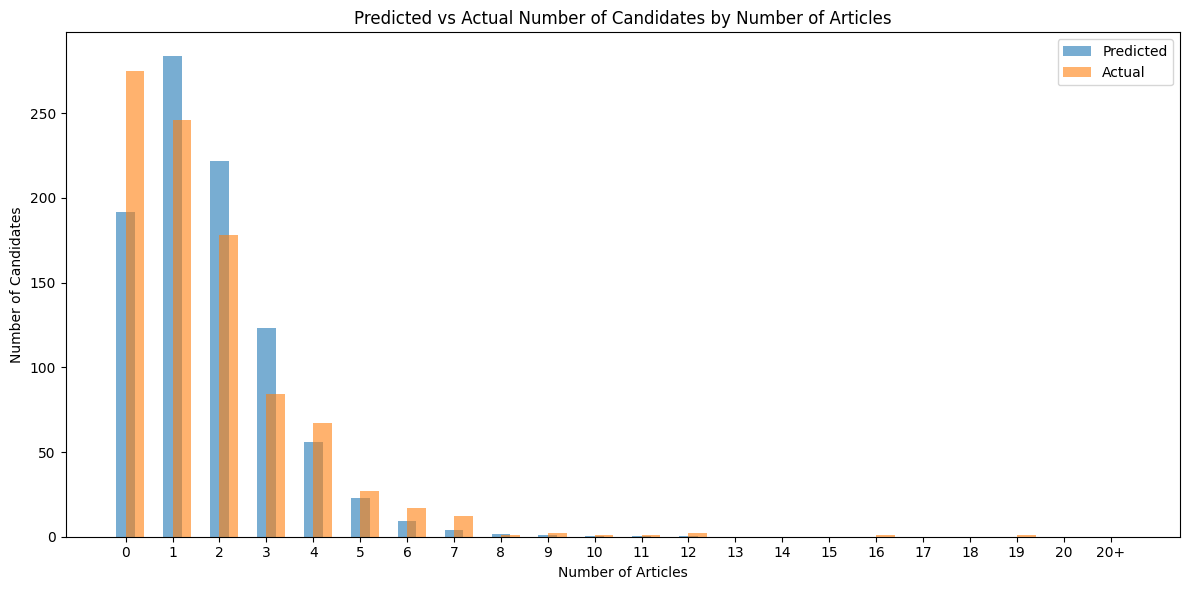

In [ ]:
# Replace '20+' with a numeric value (e.g., 21) for plotting
plot_data = pred_poisson_reg.copy()
plot_data['Number of Articles'] = plot_data['Number of Articles'].replace('20+', 21).astype(int)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.bar(plot_data['Number of Articles'], plot_data['Predicted Number of Candidates'],
        alpha=0.6, label='Predicted', width=0.4, align='center')
plt.bar(plot_data['Number of Articles'], plot_data['Actual Number of Candidates'],
        alpha=0.6, label='Actual', width=0.4, align='edge')

# Add labels and legend
plt.title('Predicted vs Actual Number of Candidates by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Candidates')
plt.xticks(ticks=plot_data['Number of Articles'], labels=pred_poisson_reg['Number of Articles'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Question 2: NBD Regression

In [ ]:
# Defining log-likelihood function for NBD Regression
def nbd_reg_ll(params, X, y):
    n, alpha, *betas = params # extracting parameters
    betas = np.array(betas)

    # calculate exp(beta * X) for each record using matrix multiplication
    exp_beta_X = np.exp(X @ betas)

    # sum of the logs of each component of the NBD Regression equation
    ll = (
        gammaln(n + y) - gammaln(n) - gammaln(y + 1) +
        n * np.log(alpha / (alpha + exp_beta_X)) +
        y * np.log(exp_beta_X / (alpha + exp_beta_X))
    )
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# setting up input data
X = articles.drop(['articles'], axis=1)
y = articles['articles']

# initial guesses for parameters
initial_params = [.1, .5, 0, -1, 1, 1, 1]

# setting bounds
bounds = [(1e-6, None)] * 2 + [(None, None)] * X.shape[1]

# performing MLE
result_NBD_reg = minimize(
    nbd_reg_ll,
    initial_params,
    args=(X, y),
    bounds=bounds,
    tol = 1e-10,
    options={'ftol': 1e-8}
)

n_est = result_NBD_reg.x[0]
alpha_est = result_NBD_reg.x[1]
betas_est = result_NBD_reg.x[2:]

# Displaying results
print("Estimated Parameters:")
print("n:", n_est)
print("alpha:", alpha_est)
for i, beta in enumerate(betas_est, start=1):
    print(f"beta_{i}: {beta}")
print("Maximum Log-Likelihood:", -result_NBD_reg.fun)

Estimated Parameters:
n: 2.264673507872998
alpha: 1.7526426847898318
beta_1: -0.21610212224567826
beta_2: 0.15002284371905525
beta_3: -0.17616860258495623
beta_4: 0.01525624938865831
beta_5: 0.029083523004315246
Maximum Log-Likelihood: -1560.9583706914527


### Predicting number of candidates that published 0 to 20 and 20+ articles

In [ ]:
# Calculate exp(beta * X) for each record
exp_beta_X = np.exp(X @ betas_est)

# Get unique values of y for each unique number of articles
unique_counts = np.arange(0, 21)

# Calculate probability (p) for the NBD
p = alpha_est / (alpha_est + exp_beta_X)

# Create PMF matrix for each unique article count across all records
pmf_matrix = np.array([
    nbinom.pmf(unique_counts, n_est, p_i) for p_i in p
])

# Calculate predicted counts for each unique article count
predicted_counts = np.sum(pmf_matrix, axis=0)  # Sum probabilities across all observations

# Calculate the expected number of candidates with 20+ articles
expected_count_20plus = np.sum([
    np.sum(nbinom.pmf(k, n_est, p_i)) for k in range(21, 101) for p_i in p
])
predicted_counts = np.append(predicted_counts, expected_count_20plus)

# Create a DataFrame to hold predicted values
pred_nbd_reg = pd.DataFrame({
    'Number of Articles': list(unique_counts) + ['20+'],
    'Predicted Number of Candidates': predicted_counts
})

# Add actual counts to the DataFrame
article_counts = articles['articles'].value_counts().sort_index()
actual_counts = [article_counts.get(k, 0) for k in unique_counts]  # Get counts for 0–20
actual_counts.append(article_counts[21:].sum())  # Sum counts for 20+
pred_nbd_reg['Actual Number of Candidates'] = actual_counts

# Displaying results
pred_nbd_reg

,Number of Articles,Predicted Number of Candidates,Actual Number of Candidates
0,0,277.757127,275
1,1,249.126666,246
2,2,164.758058,178
3,3,97.310278,84
4,4,54.732168,67
5,5,30.247991,27
6,6,16.740033,17
7,7,9.400117,12
8,8,5.407825,1
9,9,3.209293,2


In [ ]:
# showing prediction process using 5 articles

# calculate exp(beta * X) for each record
exp_beta_X = np.exp(X @ betas_est)

# calculate p for each record
p = alpha_est / (alpha_est + exp_beta_X)

# predicting number of people with 5 articles
predicted_count_5_articles = np.sum(nbinom.pmf(5, n_est, p))
predicted_count_5_articles

30.247990574867003

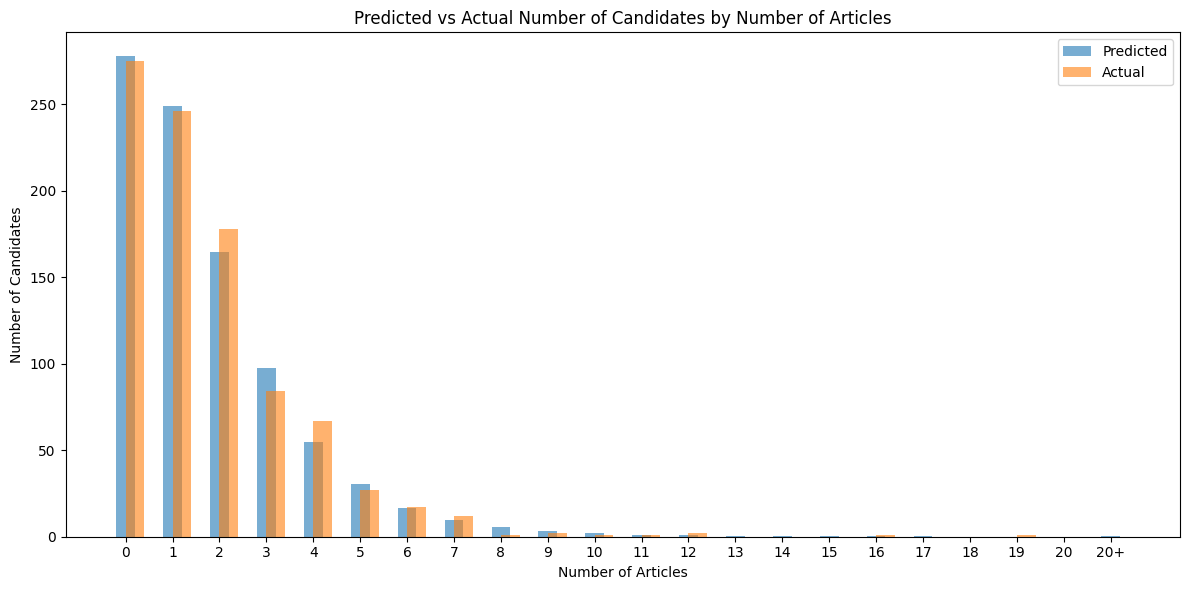

In [ ]:
# Replace '20+' with a numeric value (e.g., 21) for plotting
plot_data = pred_nbd_reg.copy()
plot_data['Number of Articles'] = plot_data['Number of Articles'].replace('20+', 21).astype(int)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.bar(plot_data['Number of Articles'], plot_data['Predicted Number of Candidates'],
        alpha=0.6, label='Predicted', width=0.4, align='center')
plt.bar(plot_data['Number of Articles'], plot_data['Actual Number of Candidates'],
        alpha=0.6, label='Actual', width=0.4, align='edge')

# Add labels and legend
plt.title('Predicted vs Actual Number of Candidates by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Candidates')
plt.xticks(ticks=plot_data['Number of Articles'], labels=pred_nbd_reg['Number of Articles'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Question 3: Zero-Inflated NBD Regression

In [ ]:
# Defining log-likelihood function for the ZI NBD Regression
def zinbd_reg_ll(params, X, y):
    pi, n, alpha, *betas = params # extracting parameters
    betas = np.array(betas)

    # calculate exp(beta * X) for each record using matrix multiplication
    exp_beta_X = np.exp(X @ betas)

    # separating components of NBD equation
    p1 = gamma(n+y) / (gamma(n) * factorial(y))
    p2 = (alpha / (alpha + exp_beta_X)) ** n
    p3 = (exp_beta_X / (alpha + exp_beta_X)) ** y

    p_no_pi = p1 * p2 * p3 # probability for NBD
    p_pi_y_0 = pi * (1 - pi) * p_no_pi # probability if y = 0
    p_pi_ygt0 = (1 - pi) * p_no_pi # probability if y > 0

    ll = np.where(y == 0, np.log(p_pi_y_0), np.log(p_pi_ygt0))
    return -np.sum(ll)

In [ ]:
# Estimating parameters using MLE

# setting up input data
X = articles.drop(['articles'], axis=1)
y = articles['articles']

# initial guesses for parameters
initial_params = [0.5, .1, .5, 0, -1, 1, 1, 1]

# setting bounds
bounds = [(1e-6, 1 - 1e-6)] + [(1e-6, None)] * 2 + [(None, None)] * X.shape[1]

# performing MLE
result_ZI_NBD_reg = minimize(
    zinbd_reg_ll,
    initial_params,
    args=(X, y),
    bounds=bounds,
    tol = 1e-10,
    options={'ftol': 1e-8}
)

# extracting parameters
pi_est = result_ZI_NBD_reg.x[0]
n_est = result_ZI_NBD_reg.x[1]
alpha_est = result_ZI_NBD_reg.x[2]
betas_est = result_ZI_NBD_reg.x[3:]

# Displaying results
print("Estimated Parameters:")
print("pi:", pi_est)
print("n:", n_est)
print("alpha:", alpha_est)
for i, beta in enumerate(betas_est, start=1):
    print(f"beta_{i}: {beta}")
print("Maximum Log-Likelihood:", -result_ZI_NBD_reg.fun)


Estimated Parameters:
pi: 0.23107840864819076
n: 2.2648647818217538
alpha: 1.7525119740286697
beta_1: -0.21658171971457593
beta_2: 0.15034469281786123
beta_3: -0.17643512902301356
beta_4: 0.015262614465058907
beta_5: 0.02907546757793069
Maximum Log-Likelihood: -2204.2639930816


### Predicting number of candidates that published 0 to 20 and 20+ articles

In [ ]:
# calculate exp(beta * X) for each record
exp_beta_X = np.exp(X @ betas_est)

# Get unique values of y for each unique number of articles
unique_counts = np.arange(0, 21)

# Calculate probability (p) for the NBD
p = alpha_est / (alpha_est + exp_beta_X)

# Create PMF matrix for each unique article count across all records
pmf_matrix = np.zeros((len(p), len(unique_counts)))

for i, p_i in enumerate(p):
    for j, k in enumerate(unique_counts):
        if k == 0:
            # for y = 0, include pi
            pmf_matrix[i, j] = pi_est + (1-pi_est) * nbinom.pmf(0, n_est, p_i)
        else:
            # for y >0, only (1 - pi) is included
            pmf_matrix[i, j] = (1 - pi_est) * nbinom.pmf(k, n_est, p_i)

# Calculate predicted counts for each unique article count
predicted_counts = np.sum(pmf_matrix, axis=0)

# expected number of candidates with 20+ articles
expected_count_20plus = np.sum([
    np.sum((1-pi_est) * nbinom.pmf(k, n_est, p_i)) for k in range(21, 101) for p_i in p
])

predicted_counts = np.append(predicted_counts, expected_count_20plus)

# DataFrame to hold predicted values
pred_zinbd_reg = pd.DataFrame({
    'Number of Articles': list(unique_counts) + ['20+'],
    'Predicted Number of Candidates': predicted_counts
})

# adding actual counts to df
article_counts = articles['articles'].value_counts().sort_index()
actual_counts = [article_counts.get(k, 0) for k in unique_counts]
actual_counts.append(article_counts[21:].sum()) # sum counts for 20+
pred_zinbd_reg['Actual Number of Candidates'] = actual_counts

# Displaying results
pred_zinbd_reg

,Number of Articles,Predicted Number of Candidates,Actual Number of Candidates
0,0,425.012549,275
1,1,191.559260,246
2,2,126.684949,178
3,3,74.823096,84
4,4,42.084463,67
5,5,23.258421,27
6,6,12.871967,17
7,7,7.228109,12
8,8,4.158268,1
9,9,2.467695,2


In [ ]:
# example of prediction calculation using 5 articles
k = 5
pmf_val = [(1-pi_est) * nbinom.pmf(k, n_est, p_i) for p_i in p]
predicted_count_5_articles = np.sum(pmf_val)
predicted_count_5_articles

23.2584207102284

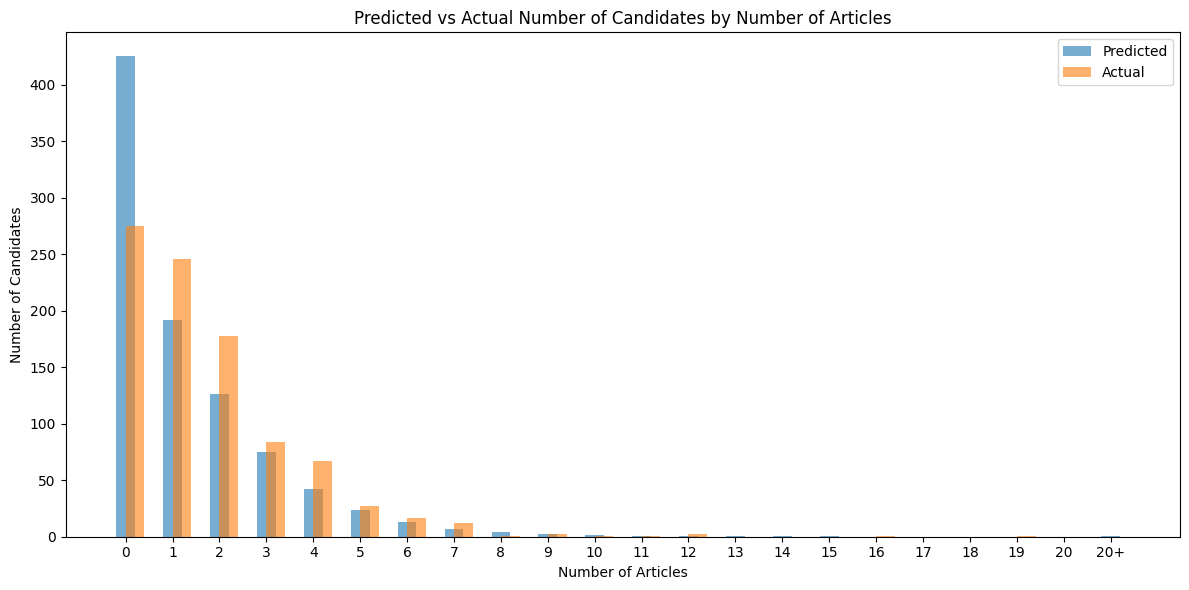

In [ ]:
# Replace '20+' with a numeric value (e.g., 21) for plotting
plot_data = pred_zinbd_reg.copy()
plot_data['Number of Articles'] = plot_data['Number of Articles'].replace('20+', 21).astype(int)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.bar(plot_data['Number of Articles'], plot_data['Predicted Number of Candidates'],
        alpha=0.6, label='Predicted', width=0.4, align='center')
plt.bar(plot_data['Number of Articles'], plot_data['Actual Number of Candidates'],
        alpha=0.6, label='Actual', width=0.4, align='edge')

# Add labels and legend
plt.title('Predicted vs Actual Number of Candidates by Number of Articles')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Candidates')
plt.xticks(ticks=plot_data['Number of Articles'], labels=pred_zinbd_reg['Number of Articles'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Question 4: Model Evaluation

### AIC & BIC Comparison

In [ ]:
# calculate AIC and BIC for each model

# Poisson Regression
aic_poisson_reg = 2 * 6 - 2 * poisson_reg_model.llf
bic_poisson_reg = np.log(len(articles)) * 6 - 2 * poisson_reg_model.llf

# NBD Regression
aic_nbd_reg = 2 * 7 - 2 * -result_NBD_reg.fun
bic_nbd_reg = np.log(len(articles)) * 7 - 2 * -result_NBD_reg.fun

# ZI NBD Regression
aic_zinbd_reg = 2 * 8 - 2 * -result_ZI_NBD_reg.fun
bic_zinbd_reg = np.log(len(articles)) * 8 - 2 * -result_ZI_NBD_reg.fun

# Creating DataFrame for comparison
model_comp = pd.DataFrame(
    {
        'Model': ['Poisson Regression', 'NBD Regression', 'ZI NBD Regression'],
        'Number of Parameters': [6, 7, 8],
        'AIC': [aic_poisson_reg, aic_nbd_reg, aic_zinbd_reg],
        'BIC': [bic_poisson_reg, bic_nbd_reg, bic_zinbd_reg]
    }
)
model_comp

,Model,Number of Parameters,AIC,BIC
0,Poisson Regression,6,3314.112632,3343.026177
1,NBD Regression,7,3135.916741,3169.649210
2,ZI NBD Regression,8,4424.527986,4463.079379


Based on both AIC and BIC, the NBD Regression is the best performing model.

### Log-Likelihood Ratio Test

In [ ]:
# Poisson vs NBD
lrt_poisson_nbd = 2 * ((-result_NBD_reg.fun) - poisson_reg_model.llf)
print("Poisson vs NBD Log-Likelihood Ratio Test:", lrt_poisson_nbd)

# NBD vs ZI NBD
lrt_nbd_zinbd = 2 * ((-result_ZI_NBD_reg.fun) - (-result_NBD_reg.fun))
print("NBD vs ZI NBD Log-Likelihood Ratio Test:", lrt_nbd_zinbd)

print('\n')

# Chi-Square Test
from scipy.stats import chi2

# Poisson vs NBD
df_pnbd = 7 - 6 # degrees of freedom
p_value_poisson_nbd = 1 - chi2.cdf(lrt_poisson_nbd, df_pnbd)
print("Poisson vs NBD Chi-Square Test P-Value:", p_value_poisson_nbd)

# NBD vs ZI NBD
df_nzinbd = 8 - 7 # degrees of freedom
p_value_nbd_zinbd = 1 - chi2.cdf(lrt_nbd_zinbd, df_nzinbd)
print("NBD vs ZI NBD Chi-Square Test P-Value:", p_value_nbd_zinbd)

Poisson vs NBD Log-Likelihood Ratio Test: 180.19589095055562
NBD vs ZI NBD Log-Likelihood Ratio Test: -1286.6112447802943


Poisson vs NBD Chi-Square Test P-Value: 0.0
NBD vs ZI NBD Chi-Square Test P-Value: 1.0


With the Log-Likelihood Ratio Test, we can say that the NBD regression provides improvement over the Poisson and that the Zero-Inflated NBD does not provide improvement over the NBD.